#  Filtrado de Base de Datos de Peliculas

---

In [1]:
# =====================================
# Importación de librerías
# =====================================

import time
inicio = time.time()

import joblib
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, KFold
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, accuracy_score, r2_score, root_mean_squared_error

In [2]:
# =====================================
# Importación de datos
# =====================================

df_peliculas = pd.read_csv("../../Fase 1 Datos/Parte 1/Puntuaciones/DatosPeliculasSeries.csv")

# CLASIFICACIÓN

---

Primero dividiremos nuestros datos entre train y test usando 1/3 parte de los datos para test y 2/3 de los datos para train.

Usaremos principalmente la parte de train en toda la práctica mienstras qué test solo se usará en la estimación del rendimiento.

In [3]:
# =====================================
# Filtrado de la base de datos
# =====================================

df_datos_cla = df_peliculas[['Tipo', 'Año', 'Duracion', 'Puntuacion', 'Num_Votos', 'Generos']].copy()
dummies = df_datos_cla["Generos"].str.get_dummies(sep=",")
dummies2 = df_datos_cla["Tipo"].str.get_dummies(sep=",")
df_datos_cla = df_datos_cla.join(dummies2).drop(columns=["Tipo"])
df_datos_cla = df_datos_cla.join(dummies).drop(columns=["Generos"])


df_datos_cla["Puntuacion"] = (
    df_datos_cla["Puntuacion"]
        .round()
        .clip(1, 10)
        .astype(int)
)

df_datos_cla["Puntuacion"].value_counts().sort_index()

Puntuacion
1       154
2      1681
3      5249
4     16108
5     28275
6     63069
7     47267
8     19192
9      1788
10       58
Name: count, dtype: int64

In [4]:
conteo = int((df_datos_cla["Puntuacion"].value_counts().min())*30)

def sample_clase(df, target):
    n = len(df)
    if n > target:
        return df.sample(n=target, random_state=100496072)
    else:
        return df

final_balanced = (
    df_datos_cla
    .groupby("Puntuacion", group_keys=False)
    .apply(sample_clase, target=conteo)
)

df_datos_cla = final_balanced.copy()

df_datos_cla["Puntuacion"].value_counts().sort_index()

C:\Users\romom\AppData\Local\Temp\ipykernel_21668\3896557210.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_datos_cla


Puntuacion
1      154
2     1681
3     1740
4     1740
5     1740
6     1740
7     1740
8     1740
9     1740
10      58
Name: count, dtype: int64

In [5]:
df_datos_cla

,Año,Duracion,Puntuacion,Num_Votos,movie,tvMiniSeries,tvSeries,tvSpecial,Action,Adult,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
54255,1972,96,1,1747,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62272,1996,83,1,885,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64932,2000,51,1,181,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65941,2012,91,1,12538,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66921,2000,90,1,141,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162972,2001,24,10,1060,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
164963,1990,55,10,1497,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
166085,2001,22,10,192,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
173162,2019,96,10,104,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# =====================================
# División entre train y test
# =====================================

col_gen = ['Año', 'Duracion', 'Puntuacion', 'Num_Votos', 'movie', 'tvSeries', 'tvMiniSeries',
           'tvSpecial', 'Thriller', 'Horror', 'Documentary', 'Sci-Fi','Romance', 'Drama', 'Sport', 'War', 'Biography',
           'Musical', 'Crime', 'Music', 'Action', 'Short', 'History', 'Comedy', 'Mystery', 'Animation', 'Adventure',
           'Family', 'Fantasy', 'Game-Show', 'Adult', 'Western', 'Talk-Show','Film-Noir']

for col in col_gen:
    if col not in df_datos_cla.columns:
        df_datos_cla[col] = 0

df_datos_cla = df_datos_cla[col_gen]

X_cla = df_datos_cla.drop(columns=["Puntuacion"])
y_cla = df_datos_cla['Puntuacion'].apply(lambda x: 'Si' if x > 5 else 'No')
notas_cla = df_datos_cla['Puntuacion']

X_train_cla, X_test_cla, y_train_cla, y_test_cla, notas_train_cla, notas_test_cla = (
    train_test_split(X_cla, y_cla, notas_cla, test_size=1/3, stratify=y_cla, random_state=100496072))

In [7]:
# =====================================
# Creación subgrupos de notas
# =====================================

idx_bajo = notas_test_cla < 3.5
idx_medio = (notas_test_cla >= 3.5) & (notas_test_cla <= 6.5)
idx_alto = notas_test_cla > 6.5

X_bajo_cla = X_test_cla[idx_bajo]
X_medio_cla = X_test_cla[idx_medio]
X_alto_cla = X_test_cla[idx_alto]

y_bajo_cla = y_test_cla[idx_bajo]
y_medio_cla = y_test_cla[idx_medio]
y_alto_cla = y_test_cla[idx_alto]

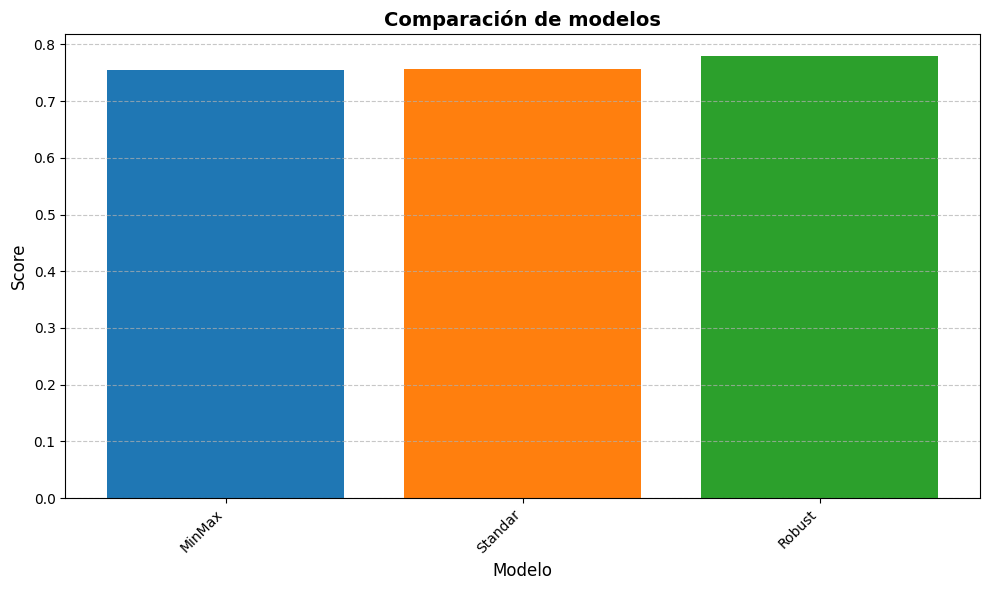


El mejor pipeline es: Pipeline(steps=[('scaler', RobustScaler()), ('modelo', KNeighborsClassifier())]), 

Score = 0.7789263867527142


In [8]:
# =====================================
# Elección del mejor método de escalado
# =====================================

inner_cla = StratifiedKFold(n_splits=3, shuffle=True, random_state=100496072)

escalado1_cla = MinMaxScaler()
escalado2_cla = StandardScaler()
escalado3_cla = RobustScaler()

knnn_cla = KNeighborsClassifier()


# Método de escalado MinMax

pipeminmax_cla = Pipeline([
    ('scaler', escalado1_cla),
    ('modelo', knnn_cla)
])

resultado1_cla = cross_val_score(pipeminmax_cla, X_train_cla, y_train_cla, scoring='balanced_accuracy', cv=inner_cla).mean()


# Método de escalado Estándar

pipeestandar_cla = Pipeline([
    ('scaler', escalado2_cla),
    ('modelo', knnn_cla)
])

resultado2_cla = cross_val_score(pipeestandar_cla, X_train_cla, y_train_cla, scoring='balanced_accuracy', cv=inner_cla).mean()


# Método de escalado Robusto

piperobusto_cla = Pipeline([
    ('scaler', escalado3_cla),
    ('modelo', knnn_cla)
])


resultado3_cla = cross_val_score(piperobusto_cla, X_train_cla, y_train_cla, scoring='balanced_accuracy', cv=inner_cla).mean()

inner_score_cla = {pipeminmax_cla: resultado1_cla, pipeestandar_cla: resultado2_cla, piperobusto_cla: resultado3_cla}

inner_score2_cla = {
    'MinMax': resultado1_cla,
    'Standar': resultado2_cla,
    'Robust': resultado3_cla
}

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(inner_score2_cla.keys(), inner_score2_cla.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparación de modelos', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

mejor_pipeline_cla = max(inner_score_cla, key=inner_score_cla.get)
print(f"\nEl mejor pipeline es: {mejor_pipeline_cla}, \n\nScore = {inner_score_cla[mejor_pipeline_cla]}")

In [9]:
# =====================================
# Evaluación KNN y Tree
# =====================================

inicioknn_cla = time.time()

knn_cla = Pipeline([
    ('scaler', mejor_pipeline_cla['scaler']),
    ('modelo', KNeighborsClassifier())
])

knn_cla = knn_cla.fit(X_train_cla, y_train_cla)
knn_score_cla = cross_val_score(knn_cla, X_train_cla, y_train_cla, cv=inner_cla, scoring='balanced_accuracy').mean()

finknn_cla = time.time()

print(f"Score: {knn_score_cla}")
print(f"Tiempo de entrenamiento para KNN: {finknn_cla - inicioknn_cla} segundos\n")



iniciotree_cla = time.time()

tree_cla = Pipeline([
    ('scaler', mejor_pipeline_cla['scaler']),
    ('modelo', DecisionTreeClassifier(random_state=100496072))
])

tree_cla.fit(X_train_cla, y_train_cla)
tree_score_cla = cross_val_score(tree_cla, X_train_cla, y_train_cla, cv=inner_cla, scoring='balanced_accuracy').mean()

fintree_cla = time.time()

print(f"Score: {tree_score_cla}")
print(f"Tiempo de entrenamiento para Árbol de Decisión: {fintree_cla - iniciotree_cla} segundos")

Score: 0.7789263867527142
Tiempo de entrenamiento para KNN: 0.6175782680511475 segundos

Score: 0.7389613435981398
Tiempo de entrenamiento para Árbol de Decisión: 0.24233031272888184 segundos


In [10]:
# =====================================
# Evaluación KNN y Tree con GridSearch
# =====================================

inicioknn_cla = time.time()

parametrosknn_cla = {
    'modelo__n_neighbors': list(range(2, 35, 1)),
    'modelo__weights': ['uniform', 'distance']
}

gridknn_cla = GridSearchCV(knn_cla, parametrosknn_cla, cv=inner_cla, scoring='balanced_accuracy', n_jobs=-1)
gridknn_cla.fit(X_train_cla, y_train_cla)

finknn_cla = time.time()

gridknn_score_cla = gridknn_cla.best_score_

print(f"Score: {gridknn_score_cla}")
print(f"Parametos: {gridknn_cla.best_params_}")
print(f"Tiempo de entrenamiento para KNN: {finknn_cla - inicioknn_cla} segundos\n")



iniciotree_cla = time.time()

parametrosarbol_cla = {
    'modelo__max_depth': list(range(2, 20, 2)),
    'modelo__min_samples_split': list(range(2, 30, 2))
}

gridtree_cla = GridSearchCV(tree_cla, parametrosarbol_cla, cv=inner_cla, scoring='balanced_accuracy', n_jobs=-1)
gridtree_cla.fit(X_train_cla, y_train_cla)
gridtree_score_cla = gridtree_cla.best_score_

fintree_cla = time.time()

print(f"Score: {gridtree_score_cla}")
print(f"Parametos: {gridtree_cla.best_params_}")
print(f"Tiempo de entrenamiento para Árbol de Decisión: {fintree_cla - iniciotree_cla} segundos")

Score: 0.7946298933571364
Parametos: {'modelo__n_neighbors': 33, 'modelo__weights': 'distance'}
Tiempo de entrenamiento para KNN: 8.95572829246521 segundos

Score: 0.7845322742465205
Parametos: {'modelo__max_depth': 8, 'modelo__min_samples_split': 26}
Tiempo de entrenamiento para Árbol de Decisión: 2.371962070465088 segundos


In [11]:
# =====================================
# Evaluación LR y SVM
# =====================================

iniciolr_cla = time.time()

lr_cla = Pipeline([
    ('scaler', mejor_pipeline_cla['scaler']),
    ('modelo', LogisticRegression(max_iter=1000, random_state=100496072))
])

lr_cla.fit(X_train_cla, y_train_cla)
lr_score_cla = cross_val_score(lr_cla, X_train_cla, y_train_cla, cv=inner_cla, scoring='balanced_accuracy').mean()

finlr_cla = time.time()

print(f"Score: {lr_score_cla}")
print(f"Tiempo de entrenamiento para ML: {finlr_cla - iniciolr_cla} segundos\n")



iniciosvm_cla = time.time()

svm_cla = Pipeline([
    ('scaler', mejor_pipeline_cla['scaler']),
    ('modelo', SVC(random_state=100496072))
])

svm_cla.fit(X_train_cla, y_train_cla)
svm_score_cla = cross_val_score(svm_cla, X_train_cla, y_train_cla, cv=inner_cla, scoring='balanced_accuracy').mean()

finsvm_cla = time.time()

print(f"Score: {svm_score_cla}")
print(f"Tiempo de entrenamiento para SVM: {finsvm_cla - iniciosvm_cla} segundos")

Score: 0.7799862462748018
Tiempo de entrenamiento para ML: 0.3379549980163574 segundos

Score: 0.5843821455317465
Tiempo de entrenamiento para SVM: 13.035797834396362 segundos


In [12]:
# =====================================
# Evaluación LR y SVM con GridSearch
# =====================================

iniciolr_cla = time.time()

parametroslr_cla = {
    'modelo__solver': ['liblinear'],
    'modelo__penalty': ['l1', 'l2'],
    'modelo__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

gridlr_cla = GridSearchCV(lr_cla, parametroslr_cla, cv=inner_cla, scoring='balanced_accuracy', n_jobs=-1)
gridlr_cla.fit(X_train_cla, y_train_cla)
gridlr_score_cla = gridlr_cla.best_score_

finlr_cla = time.time()

print(f"Score: {gridlr_score_cla}")
print(f"Tiempo de entrenamiento para ML: {finlr_cla - iniciolr_cla} segundos\n")



iniciosvm_cla = time.time()

parametrossvm_cla = {
    'modelo__kernel': ['rbf'],
    'modelo__C': [0.01, 0.1, 1, 10, 100],
    'modelo__gamma': ['scale', 'auto', 0.1, 1.01, 5.001]
}

gridsvm_cla = GridSearchCV(svm_cla, parametrossvm_cla, cv=inner_cla, scoring='balanced_accuracy', n_jobs=-1)
gridsvm_cla.fit(X_train_cla, y_train_cla)
gridsvm_score_cla = gridsvm_cla.best_score_

finsvm_cla = time.time()

print(f"Score: {gridsvm_score_cla}")
print(f"Tiempo de entrenamiento para SVM: {finsvm_cla - iniciosvm_cla} segundos")

Score: 0.7819200970197558
Tiempo de entrenamiento para ML: 0.4541497230529785 segundos

Score: 0.8001456521151186
Tiempo de entrenamiento para SVM: 37.36200952529907 segundos


In [13]:
# =====================================
# Evaluación RF sin y con GridSearch
# =====================================

iniciorf_cla = time.time()

rf_cla = Pipeline([
    ('scaler', mejor_pipeline_cla['scaler']),
    ('modelo', RandomForestClassifier(random_state=100496072))
])

rf_cla.fit(X_train_cla, y_train_cla)
rf_score_cla = cross_val_score(rf_cla, X_train_cla, y_train_cla, cv=inner_cla, scoring='balanced_accuracy').mean()

finrf_cla = time.time()

print(f"Score: {rf_score_cla}")
print(f"Tiempo de entrenamiento para ML: {finrf_cla - iniciorf_cla} segundos\n")

iniciorf_cla = time.time()

parametrosrf_cla = {
    'modelo__n_estimators': [100, 200, 500],
    'modelo__max_depth': [None, 5, 10, 20],
    'modelo__min_samples_split': [2, 5, 10],
    'modelo__min_samples_leaf': [1, 2, 4]
}

gridrf_cla = GridSearchCV(rf_cla, parametrosrf_cla, cv=inner_cla, scoring='balanced_accuracy', n_jobs=-1)
gridrf_cla.fit(X_train_cla, y_train_cla)
gridrf_score_cla = gridrf_cla.best_score_

finrf_cla = time.time()

print(f"Score: {gridrf_score_cla}")
print(f"Tiempo de entrenamiento para SVM: {finrf_cla - iniciorf_cla} segundos")

Score: 0.8047628475801772
Tiempo de entrenamiento para ML: 3.4887754917144775 segundos

Score: 0.8113730925131746
Tiempo de entrenamiento para SVM: 56.08220076560974 segundos


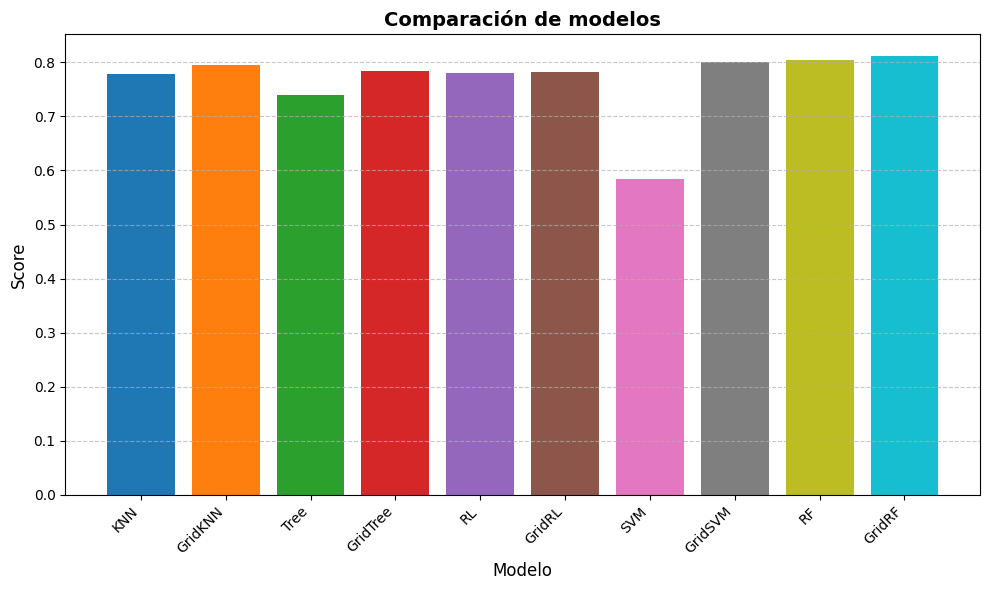


La mejor elección es: Pipeline(steps=[('scaler', RobustScaler()),
                ('modelo',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=500,
                                        random_state=100496072))]), 

Score = 0.8113730925131746


In [14]:
# =====================================
# Elección mejor clasificador
# =====================================

inner_score_global_cla = {knn_cla: knn_score_cla, tree_cla: tree_score_cla, gridknn_cla.best_estimator_: gridknn_score_cla,
                          gridtree_cla.best_estimator_: gridtree_score_cla, lr_cla: lr_score_cla, svm_cla: svm_score_cla,
                          gridlr_cla.best_estimator_: gridlr_score_cla, gridsvm_cla.best_estimator_: gridsvm_score_cla,
                          rf_cla: rf_score_cla, gridrf_cla.best_estimator_: gridrf_score_cla}

inner_score_global2_cla = {
    'KNN': knn_score_cla,
    'GridKNN': gridknn_score_cla,
    'Tree': tree_score_cla,
    'GridTree': gridtree_score_cla,
    'RL': lr_score_cla,
    'GridRL': gridlr_score_cla,
    'SVM': svm_score_cla,
    'GridSVM': gridsvm_score_cla,
    'RF': rf_score_cla,
    'GridRF': gridrf_score_cla
}

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(inner_score_global2_cla.keys(), inner_score_global2_cla.values(),
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparación de modelos', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

mejor_eleccion_cla = max(inner_score_global_cla, key=inner_score_global_cla.get)
print(f"\nLa mejor elección es: {mejor_eleccion_cla}, \n\nScore = {inner_score_global_cla[mejor_eleccion_cla]}")

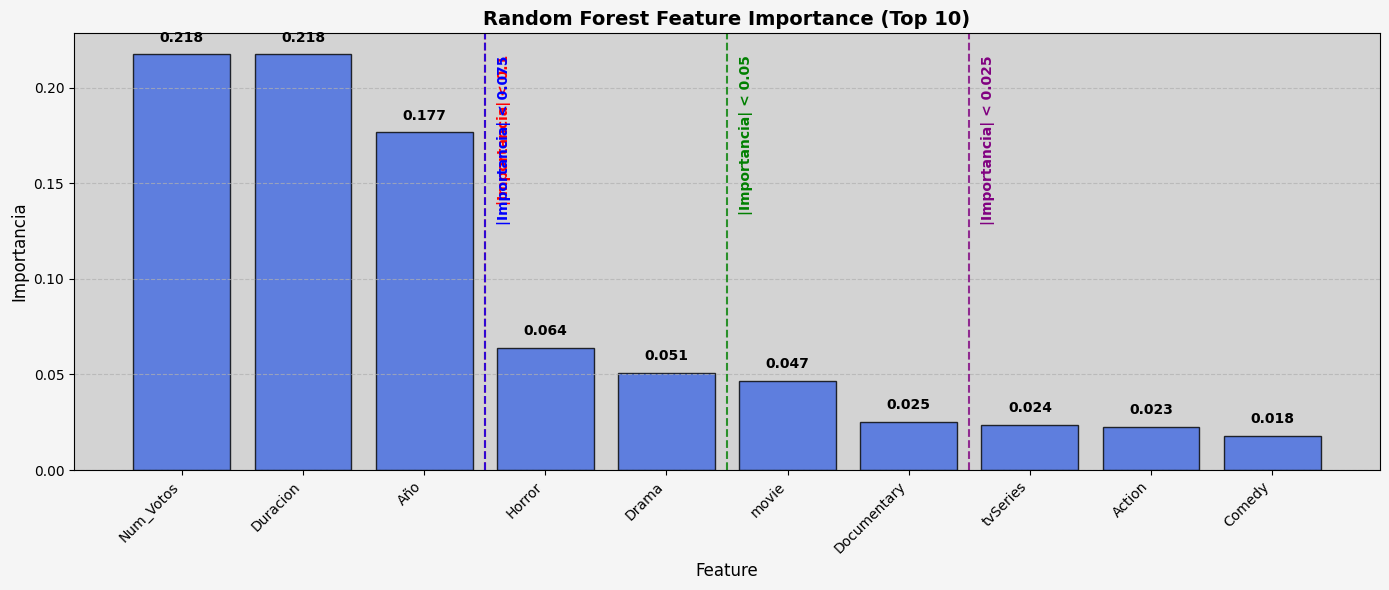

In [15]:
# =====================================
# Análisis de atributos
# =====================================

model_cla = Pipeline([
    ('scaler', mejor_pipeline_cla['scaler']),
    ('modelo', RandomForestClassifier(random_state=100496072))
])

model_cla.fit(X_train_cla, y_train_cla)

rf_estimator = model_cla.named_steps['modelo']
importances = rf_estimator.feature_importances_
feature_names = X_train_cla.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

features = top_features['Feature']
importances = top_features['Importance']

colors = np.where(importances >= 0, 'royalblue', 'crimson')

thresholds = [0.1, 0.075, 0.05, 0.025]
split_indices = {t: next((i for i, imp in enumerate(top_features['Importance'].abs()) if imp < t), len(features)) for t in thresholds}


fig, ax = plt.subplots(figsize=(14, 6), facecolor='whitesmoke')
ax.set_facecolor('lightgray')

# Barras
ax.bar(features, importances, color=colors, alpha=0.8, edgecolor='black')

# Valores de importancia sobre las barras
for i, imp in enumerate(importances):
    ax.text(i, imp + 0.005, f'{imp:.3f}', ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Líneas verticales
ax.axvline(x=split_indices[0.1] - 0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(x=split_indices[0.075] - 0.5, color='blue', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(x=split_indices[0.05] - 0.5, color='green', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(x=split_indices[0.025] - 0.5, color='purple', linestyle='--', linewidth=1.5, alpha=0.8)

# Textos de las líneas
ax.text(split_indices[0.1] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.1', color='red', rotation=90, fontsize=10, fontweight='bold', va='top')
ax.text(split_indices[0.075] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.075', color='blue', rotation=90, fontsize=10, fontweight='bold', va='top')
ax.text(split_indices[0.05] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.05', color='green', rotation=90, fontsize=10, fontweight='bold', va='top')
ax.text(split_indices[0.025] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.025', color='purple', rotation=90, fontsize=10, fontweight='bold', va='top')

# Ejes y título
ax.set_xlabel('Feature', fontsize=12, color='black')
ax.set_ylabel('Importancia', fontsize=12, color='black')
ax.set_title('Random Forest Feature Importance (Top 10)', fontsize=14, fontweight='bold', color='black')

# Ejes x
plt.xticks(rotation=45, ha='right', fontsize=10, color='black')

# Grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [16]:
# =====================================
# Análisis de los resultados
# =====================================

y_pred_test_cla = mejor_eleccion_cla.predict(X_test_cla)
print("Precisión:", balanced_accuracy_score(y_test_cla, y_pred_test_cla))

pred_bajo_cla = mejor_eleccion_cla.predict(X_bajo_cla)
pred_medio_cla = mejor_eleccion_cla.predict(X_medio_cla)
pred_alto_cla = mejor_eleccion_cla.predict(X_alto_cla)


print("\n=== SUBGRUPO: notas < 3.5 ===")
print("Accuracy:", accuracy_score(y_bajo_cla, pred_bajo_cla))
print(classification_report(y_bajo_cla, pred_bajo_cla, zero_division=0))
print(confusion_matrix(y_bajo_cla, pred_bajo_cla, labels=["Si", "No"]))


print("\n=== SUBGRUPO: 3.5 ≤ notas ≤ 6.5 ===")
print("Accuracy:", accuracy_score(y_medio_cla, pred_medio_cla))
print(classification_report(y_medio_cla, pred_medio_cla, zero_division=0))
print(confusion_matrix(y_medio_cla, pred_medio_cla, labels=["Si", "No"]))

print("\n=== SUBGRUPO: notas > 6.5 ===")
print("Accuracy:", accuracy_score(y_alto_cla, pred_alto_cla))
print(classification_report(y_alto_cla, pred_alto_cla, zero_division=0))
print(confusion_matrix(y_alto_cla, pred_alto_cla, labels=["Si", "No"]))


mejor_modelo_cla = Pipeline([
    ('scaler', mejor_eleccion_cla['scaler']),
    ('modelo', mejor_eleccion_cla['modelo'])
])


mejor_modelo_cla.fit(X_cla, y_cla)

joblib.dump(mejor_modelo_cla, 'modelo_final_IMDb_cla.pkl')

# Predecir con el modelo entrenado utilizando el conjunto completo
y_pred_completo_cla = mejor_modelo_cla.predict(X_cla)

# Evaluar la precisión sobre todo el conjunto de datos
print("\nPrecisión en el conjunto completo:", balanced_accuracy_score(y_cla, y_pred_completo_cla))

Precisión: 0.8032286931446371

=== SUBGRUPO: notas < 3.5 ===
Accuracy: 0.8511856091578087
              precision    recall  f1-score   support

          No       1.00      0.85      0.92      1223
          Si       0.00      0.00      0.00         0

    accuracy                           0.85      1223
   macro avg       0.50      0.43      0.46      1223
weighted avg       1.00      0.85      0.92      1223

[[   0    0]
 [ 182 1041]]

=== SUBGRUPO: 3.5 ≤ notas ≤ 6.5 ===
Accuracy: 0.696078431372549
              precision    recall  f1-score   support

          No       0.77      0.76      0.77      1129
          Si       0.56      0.58      0.57       605

    accuracy                           0.70      1734
   macro avg       0.67      0.67      0.67      1734
weighted avg       0.70      0.70      0.70      1734

[[349 256]
 [271 858]]

=== SUBGRUPO: notas > 6.5 ===
Accuracy: 0.8765859284890427
              precision    recall  f1-score   support

          No       0.00   

# REGRESIÓN

---

In [17]:
# =====================================
# Filtrado de la base de datos
# =====================================

df_datos_reg = df_peliculas[['Tipo', 'Año', 'Duracion', 'Puntuacion', 'Num_Votos', 'Generos']].copy()
dummies = df_datos_reg["Generos"].str.get_dummies(sep=",")
dummies2 = df_datos_reg["Tipo"].str.get_dummies(sep=",")
df_datos_reg = df_datos_reg.join(dummies2).drop(columns=["Tipo"])
df_datos_reg = df_datos_reg.join(dummies).drop(columns=["Generos"])

df_datos_reg["Puntuacion"] = (
    df_datos_reg["Puntuacion"]
        .round()
        .clip(1, 10)
        .astype(int)
)

df_datos_reg['Puntuacion'] /= 10

df_datos_reg["Puntuacion"].value_counts().sort_index()

Puntuacion
0.1      154
0.2     1681
0.3     5249
0.4    16108
0.5    28275
0.6    63069
0.7    47267
0.8    19192
0.9     1788
1.0       58
Name: count, dtype: int64

In [18]:
conteo = int((df_datos_reg["Puntuacion"].value_counts().min())*30)

def sample_clase(df, target):
    n = len(df)
    if n > target:
        return df.sample(n=target, random_state=100496072)
    else:
        return df

final_balanced = (
    df_datos_reg
    .groupby("Puntuacion", group_keys=False)
    .apply(sample_clase, target=conteo)
)

df_datos_reg = final_balanced.copy()

df_datos_reg["Puntuacion"].value_counts().sort_index()

C:\Users\romom\AppData\Local\Temp\ipykernel_21668\3075444603.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_datos_reg


Puntuacion
0.1     154
0.2    1681
0.3    1740
0.4    1740
0.5    1740
0.6    1740
0.7    1740
0.8    1740
0.9    1740
1.0      58
Name: count, dtype: int64

In [19]:
# =====================================
# División entre train y test
# =====================================

col_gen = ['Año', 'Duracion', 'Puntuacion', 'Num_Votos', 'movie', 'tvSeries', 'tvMiniSeries',
           'tvSpecial', 'Thriller', 'Horror', 'Documentary', 'Sci-Fi','Romance', 'Drama', 'Sport', 'War', 'Biography',
           'Musical', 'Crime', 'Music', 'Action', 'Short', 'History', 'Comedy', 'Mystery', 'Animation', 'Adventure',
           'Family', 'Fantasy', 'Game-Show', 'Adult', 'Western', 'Talk-Show','Film-Noir']

for col in col_gen:
    if col not in df_datos_reg.columns:
        df_datos_reg[col] = 0

df_datos_reg = df_datos_reg[col_gen]

X_reg = df_datos_reg.drop("Puntuacion", axis=1)
y_reg = df_datos_reg["Puntuacion"]

X_train_reg, X_test_reg, y_train_reg, y_test_reg = (train_test_split(X_reg, y_reg, test_size=1/3, random_state=100496072))

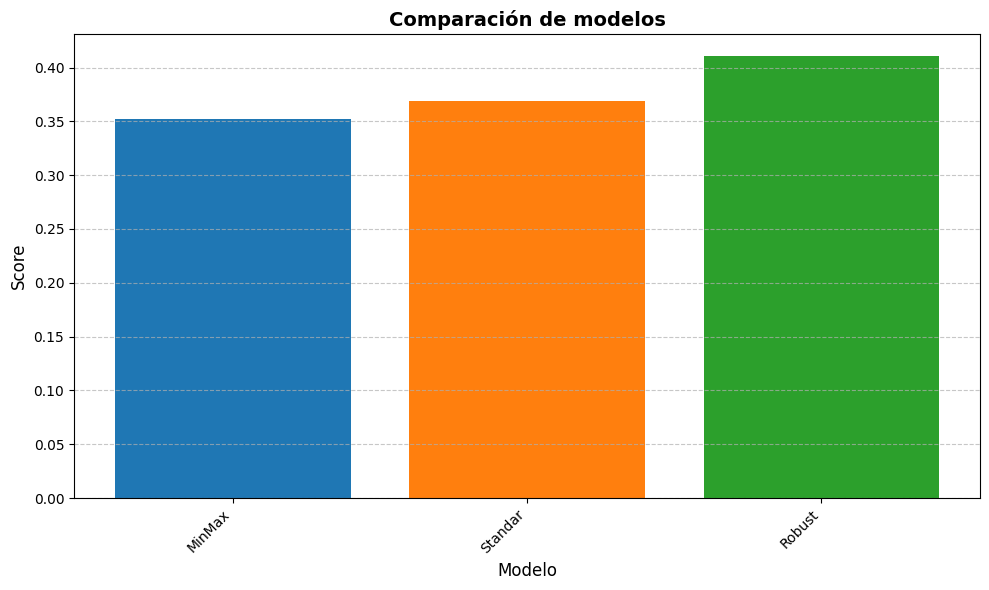


El mejor pipeline es: Pipeline(steps=[('scaler', RobustScaler()), ('modelo', KNeighborsRegressor())]), 
Score = 0.41037442761245974


In [20]:
# =====================================
# Elección del mejor método de escalado
# =====================================

inner_reg = KFold(n_splits=3, shuffle=True, random_state=100496072)

escalado1_reg = MinMaxScaler()
escalado2_reg = StandardScaler()
escalado3_reg = RobustScaler()

knnn_reg = KNeighborsRegressor()


# Método de escalado MinMax

pipeminmax_reg = Pipeline([
    ('scaler', escalado1_reg),
    ('modelo', knnn_reg)
])

resultado1_reg = cross_val_score(pipeminmax_reg, X_train_reg, y_train_reg, scoring='r2', cv=inner_reg).mean()


# Método de escalado Estándar

pipeestandar_reg = Pipeline([
    ('scaler', escalado2_reg),
    ('modelo', knnn_reg)
])

resultado2_reg = cross_val_score(pipeestandar_reg, X_train_reg, y_train_reg, scoring='r2', cv=inner_reg).mean()


# Método de escalado Robusto

piperobusto_reg = Pipeline([
    ('scaler', escalado3_reg),
    ('modelo', knnn_reg)
])


resultado3_reg = cross_val_score(piperobusto_reg, X_train_reg, y_train_reg, scoring='r2', cv=inner_reg).mean()

inner_score_reg = {pipeminmax_reg: resultado1_reg, pipeestandar_reg: resultado2_reg, piperobusto_reg: resultado3_reg}

inner_score2_reg = {
    'MinMax': resultado1_reg,
    'Standar': resultado2_reg,
    'Robust': resultado3_reg
}

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(inner_score2_reg.keys(), inner_score2_reg.values(), color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Comparación de modelos', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

mejor_pipeline_reg = max(inner_score_reg, key=inner_score_reg.get)
print(f"\nEl mejor pipeline es: {mejor_pipeline_reg}, \nScore = {inner_score_reg[mejor_pipeline_reg]}")

In [21]:
# =====================================
# Evaluación KNN y Tree con GridSearch
# =====================================

inicioknn_reg = time.time()

knn_reg = Pipeline([
    ('scaler', mejor_pipeline_reg['scaler']),
    ('modelo', KNeighborsRegressor())
])

parametrosknn_reg = {
    'modelo__n_neighbors': list(range(2, 35, 1)),
    'modelo__weights': ['uniform', 'distance']
}

gridknn_reg = GridSearchCV(knn_reg, parametrosknn_reg, cv=inner_reg, scoring='r2', n_jobs=-1)
gridknn_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = gridknn_reg.predict(X_test_reg)

rmse_knn_reg = root_mean_squared_error(y_test_reg, y_pred_reg)
best_gbr = gridknn_reg.best_estimator_

finknn_reg = time.time()

print("Mejores hiperparámetros:", gridknn_reg.best_params_)
print("RMSE:", rmse_knn_reg)
print("R2:", r2_score(y_test_reg, y_pred_reg))
print(f"Tiempo de entrenamiento para KNN: {finknn_reg - inicioknn_reg} segundos\n")



iniciotree_reg = time.time()

tree_reg = Pipeline([
    ('scaler', mejor_pipeline_reg['scaler']),
    ('modelo', DecisionTreeRegressor(random_state=100496072))
])

parametrosarbol_reg = {
    'modelo__max_depth': list(range(2, 20, 2)),  # Probar profundidades del árbol de 2 a 20
    'modelo__min_samples_split': list(range(2, 30, 2))  # Probar valores de min_samples_split entre 2 y 30
}

gridtree_reg = GridSearchCV(tree_reg, parametrosarbol_reg, cv=inner_reg, scoring='r2', n_jobs=-1)
gridtree_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = gridtree_reg.predict(X_test_reg)

rmse_tree_reg = root_mean_squared_error(y_test_reg, y_pred_reg)
best_gbr = gridtree_reg.best_estimator_

fintree_reg = time.time()

print("Mejores hiperparámetros:", gridtree_reg.best_params_)
print("RMSE:", rmse_tree_reg)
print("R2:", r2_score(y_test_reg, y_pred_reg))
print(f"Tiempo de entrenamiento para KNN: {fintree_reg - iniciotree_reg} segundos\n")

Mejores hiperparámetros: {'modelo__n_neighbors': 24, 'modelo__weights': 'distance'}
RMSE: 0.16766033688780793
R2: 0.4822497046081442
Tiempo de entrenamiento para KNN: 3.827364444732666 segundos

Mejores hiperparámetros: {'modelo__max_depth': 8, 'modelo__min_samples_split': 28}
RMSE: 0.17630523635135087
R2: 0.4274807299423523
Tiempo de entrenamiento para KNN: 1.9632301330566406 segundos



In [22]:
# =====================================
# Evaluación LR con GridSearch
# =====================================

iniciolr_reg = time.time()

lr_reg = Pipeline([
    ('scaler', mejor_pipeline_reg['scaler']),
    ('modelo', LinearRegression())
])

parametroslr_reg = {
}

gridlr_reg = GridSearchCV(lr_reg, parametroslr_reg, cv=inner_reg, scoring='r2', n_jobs=-1)
gridlr_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = gridlr_reg.predict(X_test_reg)

rmse_lr_reg = root_mean_squared_error(y_test_reg, y_pred_reg)
best_gbr = gridlr_reg.best_estimator_

finlr_reg = time.time()

print("Mejores hiperparámetros:", gridlr_reg.best_params_)
print("RMSE:", rmse_lr_reg)
print("R2:", r2_score(y_test_reg, y_pred_reg))
print(f"Tiempo de entrenamiento para ML: {finlr_reg - iniciolr_reg} segundos\n")




# =====================================
# Evaluación RF con GridSearch
# =====================================

iniciorf_reg = time.time()

rf_reg = Pipeline([
    ('scaler', mejor_pipeline_reg['scaler']),
    ('modelo', RandomForestRegressor(random_state=100496072))
])

parametrosrf_reg = {
    'modelo__n_estimators': [100, 200, 500],
    'modelo__max_depth': [None, 5, 10, 20],
    'modelo__min_samples_split': [2, 5, 10],
    'modelo__min_samples_leaf': [1, 2, 4]
}

gridrf_reg = GridSearchCV(rf_reg, parametrosrf_reg, cv=inner_reg, scoring='r2', n_jobs=-1)
gridrf_reg.fit(X_train_reg, y_train_reg)
y_pred_reg = gridrf_reg.predict(X_test_reg)

rmse_rf_reg = root_mean_squared_error(y_test_reg, y_pred_reg)
best_gbr = gridrf_reg.best_estimator_

finmrf_reg = time.time()

print("Mejores hiperparámetros:", gridrf_reg.best_params_)
print("RMSE:", rmse_rf_reg)
print("R2:", r2_score(y_test_reg, y_pred_reg))
print(f"Tiempo de entrenamiento para ML: {finmrf_reg - iniciorf_reg} segundos\n")

Mejores hiperparámetros: {}
RMSE: 0.18169687327072112
R2: 0.3919285765762487
Tiempo de entrenamiento para ML: 0.1852724552154541 segundos

Mejores hiperparámetros: {'modelo__max_depth': 20, 'modelo__min_samples_leaf': 2, 'modelo__min_samples_split': 10, 'modelo__n_estimators': 500}
RMSE: 0.16278300014067332
R2: 0.5119348668876706
Tiempo de entrenamiento para ML: 185.800151348114 segundos



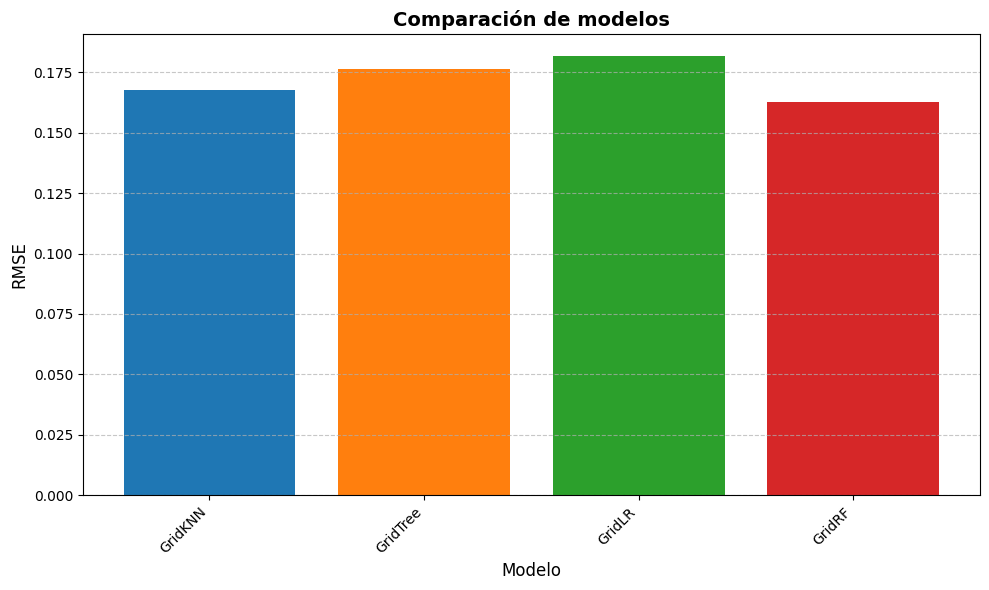


La mejor elección es: Pipeline(steps=[('scaler', RobustScaler()),
                ('modelo',
                 RandomForestRegressor(max_depth=20, min_samples_leaf=2,
                                       min_samples_split=10, n_estimators=500,
                                       random_state=100496072))]), 

RMSE = 0.16278300014067332


In [23]:
# =====================================
# Elección mejor regresor
# =====================================

inner_score_global_reg = {gridknn_reg.best_estimator_: rmse_knn_reg,
                          gridtree_reg.best_estimator_: rmse_tree_reg,
                          gridlr_reg.best_estimator_: rmse_lr_reg,
                          gridrf_reg.best_estimator_: rmse_rf_reg}

inner_score_global2_reg = {
    'GridKNN': rmse_knn_reg,
    'GridTree': rmse_tree_reg,
    'GridLR': rmse_lr_reg,
    'GridRF': rmse_rf_reg
}

# Gráfico de comparación
plt.figure(figsize=(10, 6))
plt.bar(inner_score_global2_reg.keys(), inner_score_global2_reg.values(),
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#17becf'])
plt.xlabel('Modelo', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Comparación de modelos', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

mejor_eleccion_reg = min(inner_score_global_reg, key=inner_score_global_reg.get)
print(f"\nLa mejor elección es: {mejor_eleccion_reg}, \n\nRMSE = {inner_score_global_reg[mejor_eleccion_reg]}")

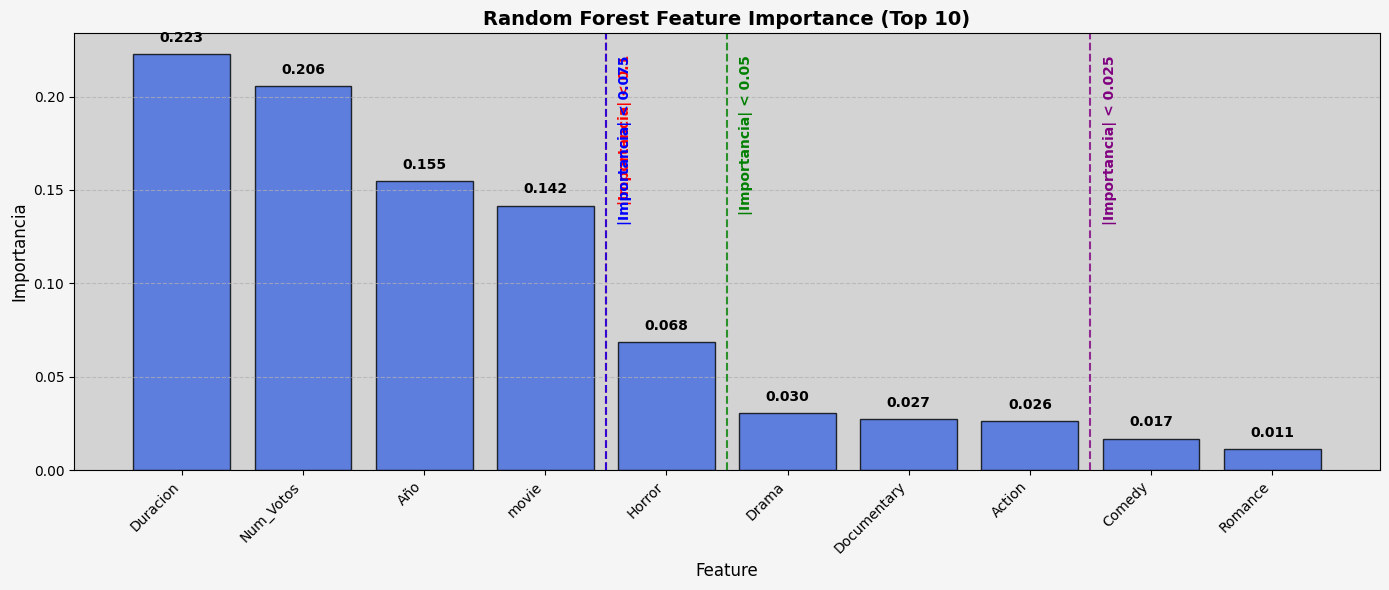

In [24]:
# =====================================
# Análisis de atributos
# =====================================

model_reg = Pipeline([
    ('scaler', mejor_pipeline_reg['scaler']),
    ('modelo', RandomForestRegressor(random_state=100496072))
])

model_reg.fit(X_train_reg, y_train_reg)

rf_estimator = model_reg.named_steps['modelo']
importances = rf_estimator.feature_importances_
feature_names = X_train_reg.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
top_features = feature_importances.sort_values(by='Importance', ascending=False).head(10)

features = top_features['Feature']
importances = top_features['Importance']

colors = np.where(importances >= 0, 'royalblue', 'crimson')

thresholds = [0.1, 0.075, 0.05, 0.025]
split_indices = {t: next((i for i, imp in enumerate(top_features['Importance'].abs()) if imp < t), len(features)) for t in thresholds}


fig, ax = plt.subplots(figsize=(14, 6), facecolor='whitesmoke')
ax.set_facecolor('lightgray')

# Barras
ax.bar(features, importances, color=colors, alpha=0.8, edgecolor='black')

# Valores de importancia sobre las barras
for i, imp in enumerate(importances):
    ax.text(i, imp + 0.005, f'{imp:.3f}', ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# Líneas verticales
ax.axvline(x=split_indices[0.1] - 0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(x=split_indices[0.075] - 0.5, color='blue', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(x=split_indices[0.05] - 0.5, color='green', linestyle='--', linewidth=1.5, alpha=0.8)
ax.axvline(x=split_indices[0.025] - 0.5, color='purple', linestyle='--', linewidth=1.5, alpha=0.8)

# Textos de las líneas
ax.text(split_indices[0.1] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.1', color='red', rotation=90, fontsize=10, fontweight='bold', va='top')
ax.text(split_indices[0.075] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.075', color='blue', rotation=90, fontsize=10, fontweight='bold', va='top')
ax.text(split_indices[0.05] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.05', color='green', rotation=90, fontsize=10, fontweight='bold', va='top')
ax.text(split_indices[0.025] - 0.5 + 0.1, ax.get_ylim()[1]*0.95, '|Importancia| < 0.025', color='purple', rotation=90, fontsize=10, fontweight='bold', va='top')

# Ejes y título
ax.set_xlabel('Feature', fontsize=12, color='black')
ax.set_ylabel('Importancia', fontsize=12, color='black')
ax.set_title('Random Forest Feature Importance (Top 10)', fontsize=14, fontweight='bold', color='black')

# Ejes x
plt.xticks(rotation=45, ha='right', fontsize=10, color='black')

# Grid
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [25]:
# =====================================
# Análisis de los resultados
# =====================================

y_pred_test_reg = mejor_eleccion_reg.predict(X_test_reg)

rmse_rf_reg = root_mean_squared_error(y_test_reg, y_pred_test_reg)
print("RMSE:", rmse_rf_reg)
print("R2:", r2_score(y_test_reg, y_pred_test_reg))


mejor_modelo_reg = Pipeline([
    ('scaler', mejor_eleccion_reg['scaler']),
    ('modelo', mejor_eleccion_reg['modelo'])
])


mejor_modelo_reg.fit(X_reg, y_reg)

joblib.dump(mejor_modelo_reg, 'modelo_final_IMDb_reg.pkl')

# Predecir con el modelo entrenado utilizando el conjunto completo
y_pred_completo_reg = mejor_modelo_reg.predict(X_reg)

# Evaluar la precisión sobre todo el conjunto de datos
rmse_rf_reg = root_mean_squared_error(y_reg, y_pred_completo_reg)
print("\nRMSE:", rmse_rf_reg)
print("R2:", r2_score(y_reg, y_pred_completo_reg))

RMSE: 0.16278300014067332
R2: 0.5119348668876706

RMSE: 0.11445248578674716
R2: 0.7594839602321133


# Pruebas

---

In [26]:
# =====================================
# Selección película a probar
# =====================================

tid = "tt0499549"

informacion = df_peliculas[(df_peliculas["tid"] == tid)]

a_predecir = informacion[['Tipo', 'Año', 'Duracion', 'Num_Votos', 'Generos']].copy()

dummies = a_predecir["Generos"].str.get_dummies(sep=",")
dummies2 = a_predecir["Tipo"].str.get_dummies(sep=",")
a_predecir = a_predecir.join(dummies2).drop(columns=["Tipo"])
a_predecir = a_predecir.join(dummies).drop(columns=["Generos"])

a_predecir = pd.DataFrame(a_predecir)

col_gen = ['Año', 'Duracion', 'Num_Votos', 'movie', 'tvSeries', 'tvMiniSeries',
           'tvSpecial', 'Thriller', 'Horror', 'Documentary', 'Sci-Fi','Romance', 'Drama', 'Sport', 'War', 'Biography',
           'Musical', 'Crime', 'Music', 'Action', 'Short', 'History', 'Comedy', 'Mystery', 'Animation', 'Adventure',
           'Family', 'Fantasy', 'Game-Show', 'Adult', 'Western', 'Talk-Show','Film-Noir']


missing = [c for c in col_gen if c not in a_predecir.columns]
if missing:
    for c in missing:
        a_predecir[c] = 0

a_predecir = a_predecir[col_gen]

In [27]:
# =====================================
# Resultados película a probar
# =====================================
print(informacion[["Puntuacion"]])
print(a_predecir[['Año', 'Duracion', 'Num_Votos']])

modelo_final_cla = joblib.load("modelo_final_IMDb_cla.pkl")
prediccion = modelo_final_cla.predict(a_predecir)
predicciones = pd.DataFrame(prediccion, columns=['Predicciones'])
print("\n\nClasificación: ",prediccion[0])

modelo_final_reg = joblib.load("modelo_final_IMDb_reg.pkl")
prediccion = modelo_final_reg.predict(a_predecir)
predicciones = pd.DataFrame(prediccion, columns=['Predicciones'])
print(f"\nRegressión: {int(prediccion[0]*100)}%")

       Puntuacion
86015         7.9
        Año  Duracion  Num_Votos
86015  2009       162    1455251


Clasificación:  Si

Regressión: 84%


In [28]:
# =====================================
# Tiempo total
# =====================================

final = time.time()
print(f"Tiempo total: {(final-inicio)/60} minutos")

Tiempo total: 6.135556983947754 minutos
